In [40]:
import spacy
import re
import pickle
import ast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, hamming_loss, jaccard_score
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from datasets import load_metric

In [2]:
from models import description,trad,functions
from vect import simi

Files already downloaded and verified


In [3]:
df=trad.final('c:/Stage/Furtwangen/excel.xlsx')


desc = []
i = 0
try:
    with open('desc_progress.pkl', 'rb') as f:
        desc = pickle.load(f)
except FileNotFoundError:
    pass

for x in df['Bildbez'][len(desc):]:  
    print(i)
    path = f'../Images/{x}.jpg'
    try:
        res = description.results(path)
        c = description.compare_lists(res[1], res[2], res[3])
        f = description.score(c[0], c[1], c[2], res[0])
        if f[1] > 0.5:
            detail = description.details(path, res)
            a = [f[0]]
            for y in detail:
                a.append(y)
            desc.append(a)
        else:
            desc.append([''])

    except FileNotFoundError:
        desc.append([''])


    with open('desc_progress.pkl', 'wb') as f:
        pickle.dump(desc, f)

    i += 1

df.to_excel('ready.xlsx',index=False)

In [2]:
df=pd.read_excel('ready.xlsx')
df1=pd.read_excel('excel.xlsx')
df['class']=df1['Hauptoberkategorie']

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return value

df['Description']=df['Description'].apply(convert_to_list)  #When loading a axcel file, all values will be strings so we need to convert them back to list

for col in df.columns:
    if col in ['Photo scene','Photo title','Note','Description']:   
        df[col]=df[col].fillna('')
    else:
        df[col]=df[col].fillna(0)

In [ ]:

x=x=[df['Photo scene'],df['Photo title'],df['Note']]
df=df.drop(columns=['Photo scene','Photo title','Note'])

a=[]
for i in x[0]:
    numbers = re.findall(r'-?\d+\.?\d*', i)
    a.append([int(num) if num.isdigit() else float(num) for num in numbers])


b=[]
for i in x[1]:
    if type(i)==str:
        numbers = re.findall(r'-?\d+\.?\d*', i)
        b.append([int(num) if num.isdigit() else float(num) for num in numbers])
    else:
        b.append(i)

c=[]
for i in x[2]:
    if type(i)==str:
        numbers = re.findall(r'-?\d+\.?\d*', i)
        c.append([int(num) if num.isdigit() else float(num) for num in numbers])
    else:
        c.append(i)

        
df['Photo motif']=a
df['Photo title']=b
df['Note']=c



In [5]:
benchmark=functions.benchmark(df)
y_pred=functions.prediction_list(df[['Photo scene','Photo title','Note','Description']],benchmark)

In [3]:
y_pred=pd.read_csv('y_pred.csv')

In [21]:
labels=df.drop(columns=['Bildbez','Productivity','Photo scene','Photo title','Note','class','Description'])

In [48]:
# Concatenate sentence columns into a single text field
df_text = df['Photo scene'] + ' ' + df['Photo title'] + ' ' + df['Note'].fillna('') + ' ' + df['Description'].apply(lambda x: ' '.join(x))

# Extract labels
label=df.drop(columns=['Bildbez','Productivity','Photo scene','Photo title','Note','class','Description'])
label_columns = label.columns
df_labels = df[label_columns].values

# Split dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df_text, df_labels, test_size=0.2, random_state=42)
# Convert numpy arrays to torch tensors
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',cache_dir='c:/Stage/cache')

# Tokenize dataset
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

# Convert to Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels_tensor
})
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels_tensor
})

# Define model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_columns), problem_type="multi_label_classification")

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',  
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


from datasets import load_metric

# Load the accuracy and F1 score metrics
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

def metric(eval_pred):
    predictions, labels = eval_pred
    predictions = (predictions > 0.5).astype(int)  # Convert to int
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "eval_f1": f1}



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=metric
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Make predictions
predictions = trainer.predict(val_dataset)
pred_probs = torch.sigmoid(torch.tensor(predictions.predictions))
pred_labels = (pred_probs > 0.5).int()

# Calculate accuracy and other metrics
accuracy = accuracy_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Stage\internship\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\Stage\internship\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can 

  0%|          | 0/105 [00:00<?, ?it/s]

{'loss': 0.6408, 'grad_norm': 1.217586636543274, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.29}
{'loss': 0.5498, 'grad_norm': 1.0713412761688232, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}
{'loss': 0.496, 'grad_norm': 0.9491658806800842, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.86}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Stage\internship\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_f1': 0.0, 'eval_loss': 0.4529695212841034, 'eval_accuracy': 0.0, 'eval_runtime': 23.2641, 'eval_samples_per_second': 3.052, 'eval_steps_per_second': 0.387, 'epoch': 1.0}
{'loss': 0.4521, 'grad_norm': 0.8603078722953796, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}
{'loss': 0.4242, 'grad_norm': 0.6879740357398987, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}
{'loss': 0.4036, 'grad_norm': 0.704913854598999, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}
{'loss': 0.3932, 'grad_norm': 0.8536200523376465, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Stage\internship\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_f1': 0.0, 'eval_loss': 0.39198118448257446, 'eval_accuracy': 0.0, 'eval_runtime': 23.9645, 'eval_samples_per_second': 2.963, 'eval_steps_per_second': 0.376, 'epoch': 2.0}
{'loss': 0.3829, 'grad_norm': 0.6246857643127441, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}
{'loss': 0.3815, 'grad_norm': 0.6064960956573486, 'learning_rate': 2.8571428571428573e-06, 'epoch': 2.57}
{'loss': 0.3738, 'grad_norm': 0.6046264171600342, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Stage\internship\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_f1': 0.0, 'eval_loss': 0.3790789544582367, 'eval_accuracy': 0.0, 'eval_runtime': 23.4929, 'eval_samples_per_second': 3.022, 'eval_steps_per_second': 0.383, 'epoch': 3.0}
{'train_runtime': 2755.9002, 'train_samples_per_second': 0.305, 'train_steps_per_second': 0.038, 'train_loss': 0.4459102097011748, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

c:\Stage\internship\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation Results: {'eval_f1': 0.0, 'eval_loss': 0.4529695212841034, 'eval_accuracy': 0.0, 'eval_runtime': 23.3312, 'eval_samples_per_second': 3.043, 'eval_steps_per_second': 0.386, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy: 0.0
F1 Score: 0.014367816091954023


c:\Stage\internship\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Stage\internship\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
y_test_pred=pd.DataFrame(pred_labels)
y_test_true=pd.DataFrame(val_labels)
y_test_pred.to_csv('y_test_pred.csv',index=False)
y_test_true.to_csv('y_test_true.csv',index=False)

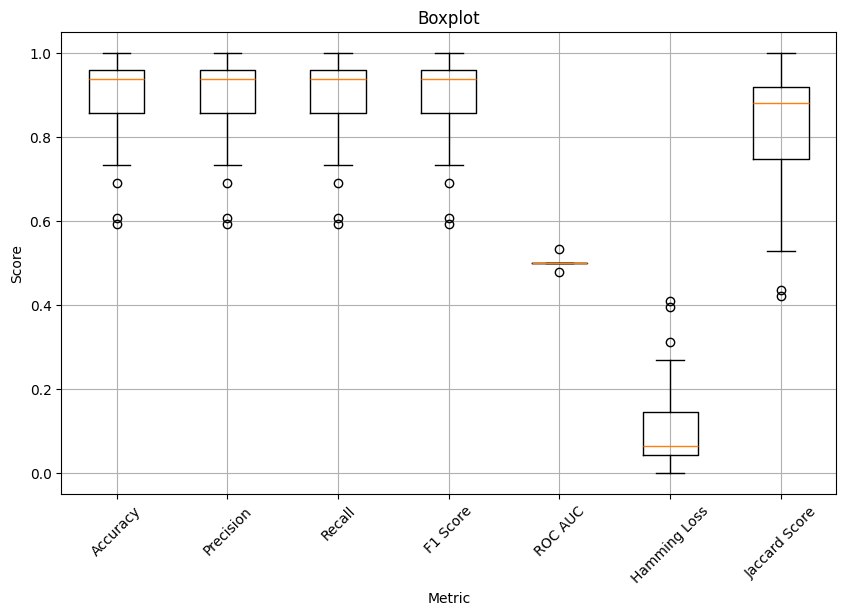

In [81]:
y_test_pred=pd.read_csv('y_test_pred.csv')
y_test_true=pd.read_csv('y_test_true.csv')


accuracy =  []
precision = [] 
recall= [] 
f1 = []  
roc_auc = []
hamming = []
jaccard = []



for i in range(len(y_test_true.columns)):
    y_pred1=y_test_pred[str(i)]
    y_true1=y_test_true[str(i)]

    accuracy.append(accuracy_score(y_true1, y_pred1))
    precision.append(precision_score(y_true1, y_pred1, average='micro')  )
    recall.append(recall_score(y_true1, y_pred1, average='micro')  )
    f1.append(f1_score(y_true1, y_pred1, average='micro')  )
    try:
        roc_auc.append(roc_auc_score(y_true1, y_pred1, average='micro')  )
    except ValueError:
        roc_auc.append(0.5)
    hamming.append(hamming_loss(y_true1, y_pred1))
    jaccard.append(jaccard_score(y_true1, y_pred1, average='micro'))


import matplotlib.pyplot as plt


data = [accuracy, precision, recall, f1, roc_auc, hamming, jaccard]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Hamming Loss', 'Jaccard Score']
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title(f'Boxplot')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [59]:
y_true=df.drop(columns=['Bildbez','Productivity','Photo scene','Photo title','Note','class','Description'])


In [10]:

accuracy =  []
precision = [] 
recall= [] 
f1 = []  
roc_auc = []
hamming = []
jaccard = []



for x in y_true.columns:
    y_true1=y_true[x]
    y_pred1=y_pred[x]

    accuracy.append(accuracy_score(y_true1, y_pred1))
    precision.append(precision_score(y_true1, y_pred1, average='micro')  )
    recall.append(recall_score(y_true1, y_pred1, average='micro')  )
    f1.append(f1_score(y_true1, y_pred1, average='micro')  )
    roc_auc.append(roc_auc_score(y_true1, y_pred1, average='micro')  )
    hamming.append(hamming_loss(y_true1, y_pred1))
    jaccard.append(jaccard_score(y_true1, y_pred1, average='micro'))
    


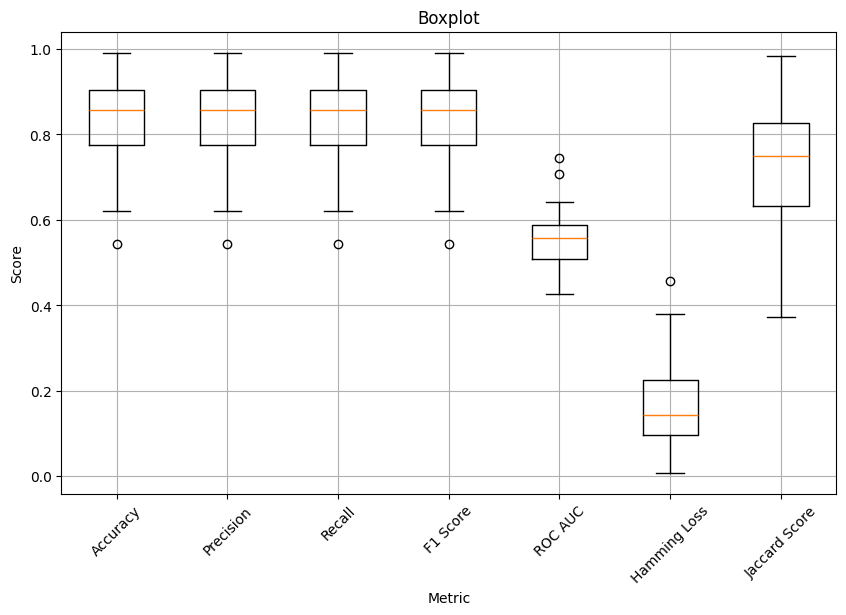

In [11]:
import matplotlib.pyplot as plt


data = [accuracy, precision, recall, f1, roc_auc, hamming, jaccard]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Hamming Loss', 'Jaccard Score']
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title(f'Boxplot')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [18]:
import pickle

desc = []
i = 0
try:
    with open('desc_progress.pkl', 'rb') as f:
        desc = pickle.load(f)
except FileNotFoundError:
    pass

for x in df['Bildbez'][len(desc):]:  
    print(i)
    path = f'../Images/{x}.jpg'
    try:
        res = description.results(path)
        c = description.compare_lists(res[1], res[2], res[3])
        f = description.score(c[0], c[1], c[2], res[0])
        if f[1] > 0.5:
            detail = description.details(path, res)
            a = [f[0]]
            for y in detail:
                a.append(y)
            desc.append(a)
        else:
            desc.append([''])

    except FileNotFoundError:
        desc.append([''])


    with open('desc_progress.pkl', 'wb') as f:
        pickle.dump(desc, f)

    i += 1


0
1

image 1/1 c:\Stage\Furtwangen\..\Images\TN14_F118.jpg: 224x224 park_bench 1.00, ashcan 0.00, folding_chair 0.00, swing 0.00, tile_roof 0.00, 168.9ms
Speed: 16.5ms preprocess, 168.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
2

image 1/1 c:\Stage\Furtwangen\..\Images\TN14_F64.jpg: 224x224 drake 0.51, American_coot 0.32, beaver 0.07, platypus 0.03, goose 0.02, 158.2ms
Speed: 19.1ms preprocess, 158.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
3

image 1/1 c:\Stage\Furtwangen\..\Images\TN14_F88.jpg: 224x224 yellow_lady's_slipper 0.88, ear 0.03, pineapple 0.03, sulphur_butterfly 0.02, daisy 0.01, 159.7ms
Speed: 30.7ms preprocess, 159.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
4

image 1/1 c:\Stage\Furtwangen\..\Images\TN14_F166.jpg: 224x224 bannister 0.79, file 0.15, medicine_chest 0.01, sliding_door 0.01, safe 0.01, 181.4ms
Speed: 11.8ms preprocess, 181.4ms inference, 0.0ms postprocess per image at shape (1, 3, 

In [ ]:
nlp = spacy.load("en_core_web_md")
desc_vec=[]
for y in desc:
    if type(y)==list:
        a=[]
        for x in y:
            a.append(nlp(x).vector)
        desc_vec.append(a)
    else:
        desc_vec.append(nlp(y).vector)

df['description']=desc_vec